# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 23th of november at noon**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "pierre"
ln1 = "ablin"
fn2 = "alexandre"
ln2 = "gramfort"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_ablin_pierre_and_gramfort_alexandre.ipynb


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [3]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

/var/folders/f0/q7nn178n5cldx0lvl6yvbbn40000gn/T/ipykernel_71737/428856815.py:4: DeprecationWarning: Please use `toeplitz` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import toeplitz


## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$


<div class="alert alert-success">
    <b>QUESTION 1:</b> We ask you to code
     <ul>
         <li>cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$</li>
         <li>greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.
</li>
    </ul>
</div>

**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [4]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [5]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] += A[:,j].T.dot(residuals) / lips_const[j]
        # update residuals:
        residuals += A[:,j]*old_w_j - A[:,j]*w[j]
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(abs(gradient))
        old_w_j = w[j]
        w[j] -= 1/lips_const[j] * gradient[j]
        # update gradient:
        gradient += gram[:,j] * w[j] - gram[:,j] * old_w_j
        # END TODO
        
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
           
    return w, np.array(all_objs)

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Compute a precise minimum with your favorite solver</li>
         <li>Compare the performance of cyclic and greedy CD as function of iterations.</li>
         <li>From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.</li>
    </ul>
</div>

**Remark:** You will do the plots using the number of iterations on the x-axis and not time as your code is likely to be slow unless you use [numba](https://numba.pydata.org/).

In [6]:
def loss(x, A, b):
    return norm(A.dot(x) - b) ** 2 / 2

def grad(x, A, b):
    return A.T.dot(A.dot(x)-b)

In [7]:
from scipy.optimize import fmin_l_bfgs_b

In [8]:
w_init = np.zeros(n_features)
w_min, f_min, _ = fmin_l_bfgs_b(loss, w_init, grad, args=(A, b), 
                                pgtol=1e-30, factr=1e-30)

In [9]:
print(f_min)
print(norm(grad(w_min, A, b)))

466.3849765337659
2.203067678248696e-05


In [10]:
n_iter = 5000

In [11]:
w_c , obj_c  = cyclic_cd(A,b,n_iter)
w_g , obj_g  = greedy_cd(A,b,n_iter)

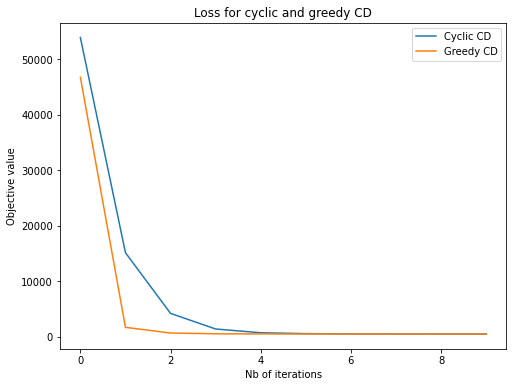

In [12]:
#plot objectives for greedy and cyclic CD
plt.figure(figsize=(8,6))
plt.plot(obj_c[:10], label="Cyclic CD")
plt.plot(obj_g[:10],label="Greedy CD")
plt.title('Loss for cyclic and greedy CD')
plt.xlabel('Nb of iterations')
plt.ylabel('Objective value')

plt.legend()
plt.show()

In [13]:
print('distance to minimizer for cyclic cd:',norm(w_c-w_min, ord=2))
print('distance to minimizer for greedy cd:',norm(w_g-w_min,ord=2))

distance to minimizer for cyclic cd: 2.136030743957847e-08
distance to minimizer for greedy cd: 2.135621182569898e-08


In [14]:
print('objective value for cyclic cd:',obj_c[-1])
print('objective value for greedy cd:',obj_g[-1])

objective value for cyclic cd: 466.3849765337657
objective value for greedy cd: 466.3849765337659


The curves show that the loss decreases at each iteration of coordinate descent for Cyclic and Greedy algorithm. They both converge to a very similare value (466.38497653). We can also see that after 5000 iterations, their distance to minimizer is approximately the same. Furthermore we can notice that greedy cd reaches the minimzer faster than Cyclic CD.This can be explained by the fact that greedy cg selects the best a good, instead of cyclic, coordinate, instead of arbitrary permutations as for cyclic cd.

From a practical point of view, 
- could you use greedy CD for L2 regularized logistic regression? 
- to solve OLS, but with 100,000 features?

- Greedy Coordinate Descent for L2 regularized logistic regression : in those kind of problems, the big number of non zero components causes the non efficiency of greedy cd as it has to go through every variable in order to find the greatest gradient. Greedy cd is more effcient with regularized problemes, meaning for sparse optimization since most zero components in the solution are never selected and thus remain zero throughout the iterations. The problem dimension effectively reduces the number of variables that are ever updated, which is relatively small. Consequently, the greedy cd iteration converges in very few iterations. The saved iterations over-weigh the extra cost of ranking the coordinates.
 
- Greedy Coordinate Descent for OLS with 100,000 features : this method requires evaluating the whole gradient vector to find the best descent and get the best index. With a big number of features this could cost expensive computational time because it introduces a higher per-iteration complexity.

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success">
    <b>QUESTION 3:</b><br/>
    Assuming uniqueness of the solution, show that: $\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.
</div>

**HINT:** You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

<div class="alert alert-succes">
    <b>Answer</b>:  

We have our objective function:
$$f=\sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$  
And we want to compute its differential :  
$$\partial f(w)=\sum_{i=1}^{n} \frac{-y_i x_i^\top}{1+\exp(y_i w^\top x_i)} + \lambda \partial \Vert . \Vert_1(w) $$


We have $\lambda \geq \lambda_{max}$ where $\lambda_{max} = \frac 12 \Vert X^\top y \Vert_{\infty}$  
Let $ v = \frac 12 X^\top y =$ where $ v = (\alpha_1,\ldots,\alpha_n)$  
Then $\lambda_{max} = \max_{i}(\alpha_i)$  
$\begin{alignat}{2}
\lambda \geq \lambda_{max} 
&\Rightarrow \forall i \in \{1,\ldots,n\} ; \lambda \geq |\alpha_i| \\ 
&\Rightarrow \alpha_i \in \lambda[-1,1] \\
&\Rightarrow v \in \lambda([-1,1] \times \ldots \times [-1,1])
\end{alignat}$  
  
However : $\partial\Vert.\Vert_1(0_p)=[-1,1] \times \ldots \times [-1,1]$  
So : $v \in \partial\Vert.\Vert_1(0_p) \Rightarrow 0\in \{-v\} + \lambda\partial\Vert.\Vert_1(0_p)$  

$$\partial f(0)=-\frac 12 \{X^\top y\}+\partial\Vert.\Vert_1(0_p)$$  
Therefore :  $$0 \in \partial f(0)$$  
We also know that according to Fermat's rule, if $f$ is a convex function, then $0 \in \arg\min f$  

- Proof  of  the convexity of f :  
We know that $\Vert . \Vert_1$ is convex  
In order to prove that the first term of f is convex, we compute its Hessian :  
$$H= \sum_{i=1}^{n} \frac{y_i^2 x_i^\top x_i \exp(y_i w^\top x_i)}{(1+\exp(y_i w^\top x_i))^2}$$  
Let $b \in \mathbf{R^n}$, then :  
$$b^\top x_i x_i^\top b=\Vert x_i^\top b\Vert ^2 \geq 0$$  
Therefore : $$H\geq 0$$  
Conclusion : $f$ is convex and $ \hat w = 0$
</div>

<div class="alert alert-success">
    <b>QUESTION 4:</b><br/>
    Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.
</div>

- Let's compute the hessian of the loss for sparse Logistic regression : 

$$ \nabla ^{2} F  = (\dfrac{\partial^{2} F_x{\omega}}{\partial \omega_{k}\omega_{j}})_{1 \le k,j \le p} $$

$$\dfrac{\partial^{2} F_x}{\partial \omega_{k}\omega_{j}} = \dfrac{\partial}{\partial \omega_{k}}(\sum_{i=1}^{n} \dfrac{-y_i \times x_{i}^{j} e^{- y_i w^\top x_i}} { 1 + e^{- y_i w^\top x_i} }) $$

Here $x_i^{k}$ refers to the feature k for the i-th sample


- We define $u_i = y_i w^\top x_i $ which gives

$$\implies \dfrac{\partial^{2} F_x}{\partial \omega_{k}\omega_{j}}  = \dfrac{\partial}{\partial \omega_{k}}(\sum_{i=1}^{n} \dfrac{-y_i \times x_{i}^{j} e^{- u_i}} { 1 + e^{- u_i} }) $$

$$\implies \dfrac{\partial^{2} F_x}{\partial \omega_{k}\omega_{j}}  = \sum_{i=1}^{n} \dfrac{y_i \times x_{i}^{j} e^{- u_i}}{(1 + e^{- u_i})^{2}} \times \dfrac{\partial u_{i}}{\partial w_{k}} $$

$$\implies \dfrac{\partial^{2} F_x}{\partial \omega_{k}\omega_{j}}  = \sum_{i=1}^{n} \dfrac{y_i \times x_{i}^{j} e^{- u_i}}{(1 + e^{- u_i})^{2}} \times y_{i} x_{i}^{k} $$

But we have the following inequality regardless of the value $u_i$ : $$\dfrac{e^{- u_i}}{(1 + e^{- u_i})^{2}} < \dfrac{1}{4}$$ 

Thus, $$ |\dfrac{\partial^{2} F_x}{\partial \omega_{k}\omega_{j}}|  \le  |\sum_{i=1}^{n} \dfrac{y_i^{2} \times x_{i}^{j} x_{i}^{k} }{4}| = |\sum_{i=1}^{n} \dfrac{x_{i}^{j} x_{i}^{k} }{4}|$$

Thus, $$|\dfrac{\partial^{2} F_x}{\partial \omega_{j}^{2}}|  \le  \sum_{i=1}^{n} \dfrac{\times x_{i}^{j} x_{i}^{j} }{4}  = \dfrac{\Vert X_{j}\Vert^{2}}{4}  $$ 

Thus, $$\forall \omega \in \mathbb{R}^{p}, \forall i \in [1,p] : $$
$$ |d_{j}^{T} \nabla ^{2}F_x(\omega) d_{j} | \le |\sum_{i=1}^{n} \dfrac{x_{i}^{j} x_{i}^{j} }{4}| = \dfrac{\Vert X_{j}\Vert^{2}}{4}, \text{ where } \\ d_{i} = (0,...,1,...,0)^{T} \text{ in i-th position}$$ 




<div class="alert alert-success">
    <b>QUESTION 5:</b><br/>
    Code cyclic proximal coordinate descent for sparse Logistic regression:
</div>

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [15]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    # TODO
    lips_const = [norm(X[:,j] , ord=2)**2 / 4 for j in range(n_features)]
    # END TODO
    all_objs = np.zeros(n_iter)

    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = -sum([y[i] * X[i,j] * sigmoid(-y[i]*Xw[i]) for i in range(n_samples)])
            w[j] = np.sign(w[j] - grad_j/lips_const[j]) * soft_thresh(w[j] - grad_j/lips_const[j], lamb/lips_const[j])
            
            if old_w_j != w[j]:
                Xw += w[j] * X[:,j] - old_w_j * X[:,j]
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

In [16]:
w_, all_objs_lc = cd_logreg(X,y,lamb,n_iter=10)

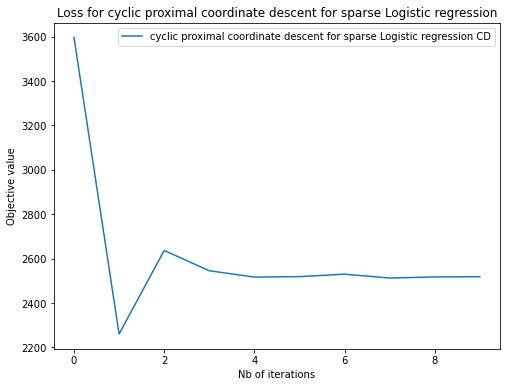

In [17]:
#plot objectives for greedy and cyclic CD
plt.figure(figsize=(8,6))
plt.plot(all_objs_lc, label="cyclic proximal coordinate descent for sparse Logistic regression CD")
plt.title('Loss for cyclic proximal coordinate descent for sparse Logistic regression')
plt.xlabel('Nb of iterations')
plt.ylabel('Objective value')

plt.legend()
plt.show()

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [18]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

In [19]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


<div class="alert alert-success">
    <b>QUESTION 6:</b> Code
    <ul>
        <li>a simple proximal gradient solver for the Lasso</li>
        <li>a prox CD solver for the Lasso and compare them on this dataset.</li>
    </ul>
</div>

**Remark:** Do the plots in terms of epochs, not updates (to be fair to CD).

- ISTA :

In [20]:
n_samples, n_features = X.shape
n=n_samples

In [21]:
def f(x): return loss_linreg(x, A, b)
def grad_f(x): return grad_linreg(x, A, b)

In [22]:
# To implement Ista , we used materials from the first lab
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""  
    return np.sign(x) * np.maximum((np.abs(x) - s) , 0) 
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s * np.linalg.norm(x , ord=1)
def loss_logreg(x):
    """Logistic loss"""
    return sum([np.log(1 + np.exp(-y[i]*np.dot(X[i],x))) for i in range(n_samples)] )

def grad_logreg(x):
    """Logistic gradient"""
    return -sum([y[i] * X[i,:].T * sigmoid(-y[i]*X[i].dot(x)) for i in range(n_samples)]) 

def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    return  (1/4) * norm(A , ord=2) ** 2

def ista(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    
    for k in range(n_iter + 1):
        x_new = prox_R(x - (1/step)*grad_f(x),lmbd)
        x = x_new
        
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [23]:
# ista results 
w0=np.zeros(n_features)
w_ista, obj_ista, err_pgd = ista(w0, loss_logreg, grad_logreg, lasso, prox_lasso, step=lip_logreg(X), lmbd=lambd, n_iter=10*n_features,verbose=False)

ValueError: operands could not be broadcast together with shapes (7129,) (100,) 

In [ ]:
#better prox cd results
w_prox, all_objs_prox = cd_logreg(X,y,lambd,n_iter=10)

In [ ]:
plt.plot(all_objs_prox[:50], label='prox CD')
plt.plot(obj_ista[:50],c='r',label = 'ISTA')
plt.ylabel('log objectives')
plt.yscale("log")
plt.xlabel("iterations")
plt.title("Plot of the objective of the minimizer (the minimum)")
plt.legend()
plt.show()

In [25]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

In [24]:
from numpy import genfromtxt
y = 2 * (genfromtxt('leukemia_big.csv', delimiter=',', dtype=str)[0] == 'ALL') - 1
X = genfromtxt('leukemia_big.csv', delimiter=',')[1:].T

print(X.shape)
print(y[::10])

FileNotFoundError: leukemia_big.csv not found.

In [26]:
lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso /5
n_samples, n_features = X.shape
n=n_samples

In [27]:
# To implement Ista , we used materials from the first lab
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""  
    return np.sign(x) * np.maximum((np.abs(x) - s) , 0) 
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s * np.linalg.norm(x , ord=1)
def loss_logreg(x):
    """Logistic loss"""
  
    return sum([np.log(1 + np.exp(-y[i]*np.dot(X[i],x))) for i in range(n_samples)] )

def grad_logreg(x):
    """Logistic gradient"""
    return -sum([y[i] * X[i,:].T * sigmoid(-y[i]*X[i].dot(x)) for i in range(n_samples)]) 

def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    return  (1/4) * norm(A , ord=2) ** 2
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = X.shape

    # objective history
    objectives = []
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x = prox_g(x - (1/step) * grad_f(x) , s/step)
        
        obj = f(x) + g(x, s)
        objectives.append(obj)
        if k % 100 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8) ]))
#                               ("%.2e" % err).rjust(8)
    return x, objectives

In [29]:
# ista results 
w0=np.zeros(n_features)
w_ista ,obj_ista =ista(w0,loss_logreg,grad_logreg,lasso,prox_lasso,step=lip_logreg(X),s=lambd,n_iter=n_features, 
                      verbose=False)

KeyboardInterrupt: 

In [23]:
#better prox cd results
w_prox, all_objs_prox = cd_logreg_better(X,y,lambd,n_iter=10)

In [24]:
v= [norm(ob-all_objs_prox[-1] ) for ob in all_objs_prox]
w= [norm(ob-all_objs_prox[-1] ) for ob in obj_ista[: :n_features]]

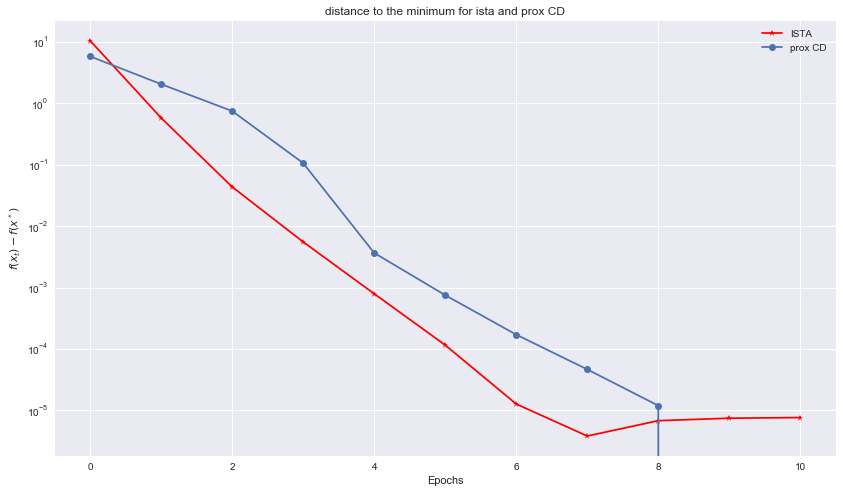

In [25]:
# comparing the performances of better proximal coordinate and ista
#in terms of distance to the last minimum obtained with better prox CD
plt.figure(figsize=(14,8))
plt.semilogy(w, 'r*-', label="ISTA")
plt.semilogy(v, 'o-',label="prox CD")
plt.title('distance to the minimum for ista and prox CD')
plt.xlabel('Epochs')
plt.ylabel('$f(x_t) - f(x^*)$')

plt.legend()
plt.show()

In [30]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


In [31]:
n_samples, n_features = X.shape
x0 = np.zeros(X.shape[1])
n_iter = 10
lmbd = lambd / 10
lips_constant = (1/4) * norm(X , ord=2) ** 2 / 4
step = lip_logreg(X)

In [32]:
cd_logreg_weight, cd_logreg_obj = cd_logreg(X, y, lambd, n_iter)
lips_constant = (1/4) * norm(X , ord=2) ** 2

In [33]:
# To implement Ista , we used materials from the first lab
def prox_L1(x, s):
    """Proximal operator for the Lasso at x"""  
    return np.sign(x) * np.maximum((np.abs(x) - s) , 0) 
    
def L1_norm(x, s):
    """Value of the Lasso penalization at x"""
    return s * np.linalg.norm(x , ord=1)
def loss_logreg(x):
    """Logistic loss"""
  
    return sum([np.log(1 + np.exp(-y[i]* (X[i] @ x))) for i in range(n_samples)] )

def grad_logreg(x):
    """Logistic gradient"""
    return -sum([y[i] * X[i,:].T * sigmoid(-y[i]*X[i].dot(x)) for i in range(n_samples)])


def ista(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = X.shape

    # objective history
    objectives = []
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    for k in range(n_iter + 1):

        x = prox_R(x - (1/step) * grad_f(x) , lmbd/step)
        
        obj = f(x) + R(x, lmbd)
        objectives.append(obj)

    return x, objectives

In [34]:
# ista  
w0=np.zeros(n_features)
w_ista ,all_obj_ista =ista(w0,loss_logreg,grad_logreg,L1_norm,prox_L1,step= step,lmbd=lambd,n_iter=10, 
                      verbose=False)

In [35]:
# cd 
cd_logreg_weight, cd_obj = cd_logreg(X, y, lambd, n_iter)

In [36]:
v= [norm(obj-cd_obj[-1] ) for obj in cd_obj]
w= [norm(obj-cd_obj[-1] ) for obj in all_obj_ista]

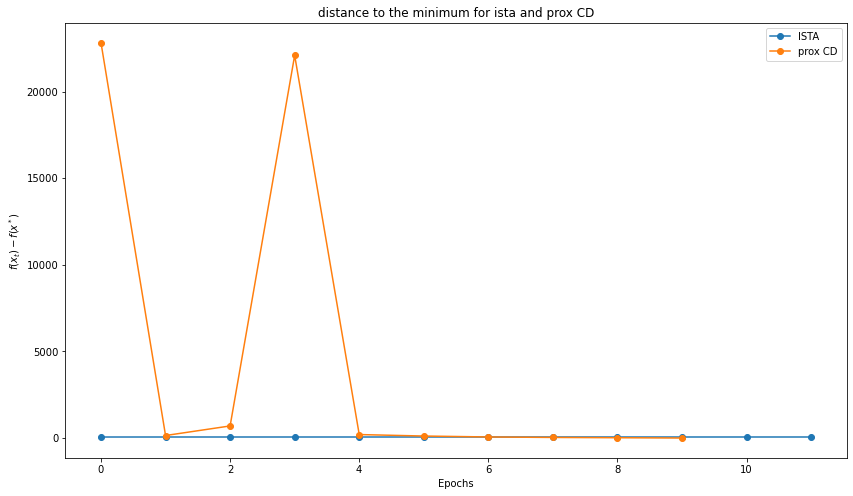

In [37]:
plt.figure(figsize=(14,8))
plt.plot(w, 'o-', label="ISTA")
plt.plot(v, 'o-',label="prox CD")
plt.title('distance to the minimum for ista and prox CD')
plt.xlabel('Epochs')
plt.ylabel('$f(x_t) - f(x^*)$')

plt.legend()
plt.show()